MERABET Mohamed Malih 22202729, 
MESSAOUDI Nor El Houda 22216866, 
SEOUDI Noha 21813399, 
ZEDDAM Lylia 21812374

#Projet Deep learning
Dans cette partie on apporte des amélioration sur notre modeleBaseLine




# 0-Installation des libraire et mise en palce de google drive 

In [ ]:
!pip install pyyaml h5py #pour sauvegarder le modèle 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importation des différentes librairies utiles pour le notebook
#Pour ignorer les warning.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle 
import pandas as pd
import numpy as np
import string
import time
import base64
import re
import sys
import copy
import random
from numpy import mean
from numpy import std
from scipy.stats import randint

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
from PIL import Image

#Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# TensorFlow et keras
import keras
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical,img_to_array, load_img #from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from tqdm import tqdm
from keras.models import load_model
from keras.models import Model
from sklearn.model_selection import KFold
from keras.layers import Dense
import os  #pour accéder aux fonctionnalité systèmes
import sys 
from os import listdir
from os.path import isfile, join
import cv2  # Library to solve computer vision problems
import glob  # = global is used to return all file paths that match a specific pattern

In [ ]:
# pour monter son Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/M2_ML_Projet'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

[Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/M2_ML_Projet'
/content


'/content'

#1- Récupération des jeux de données

In [ ]:
#pour télécharger le zip file 
!wget https://www.lirmm.fr/~poncelet/Ressources/Tiger-Fox-Elephant.zip

--2022-12-04 18:12:27--  https://www.lirmm.fr/~poncelet/Ressources/Tiger-Fox-Elephant.zip
Resolving www.lirmm.fr (www.lirmm.fr)... 193.49.104.251
Connecting to www.lirmm.fr (www.lirmm.fr)|193.49.104.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7605545 (7.3M) [application/zip]
Saving to: ‘Tiger-Fox-Elephant.zip.1’

Tiger-Fox-Elephant. 100%[===================>]   7.25M  4.45MB/s    in 1.6s    

2022-12-04 18:12:31 (4.45 MB/s) - ‘Tiger-Fox-Elephant.zip.1’ saved [7605545/7605545]



In [ ]:
import zipfile
with zipfile.ZipFile("Tiger-Fox-Elephant.zip","r") as zip_ref:
    zip_ref.extractall("Data_Project")

#2-Initialisation de fonctions globales qui serviront tout le long de notre étude.

In [ ]:
IMG_SIZE=124
COLUMNS = 16

In [ ]:
 """
 Téléchargement de jeux d'entrainement 
 @Param path_data: le chemin vers notre répertoire de données 
 @Param list_classes: la liste de nom de classe volue
 @Return training_data
 """
 def create_training_data(path_data, list_classes):  
  training_data=[]   #Tableau de retour 
  for classes in list_classes: # tiger et tiger_negative
      path = os.path.join(path_data, classes)
      class_num = list_classes.index(classes)
      for img in os.listdir(path):
        try:
          img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_UNCHANGED)
          new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
          training_data.append([new_array, class_num])  # on remplit notre tableau 
        except Exception as e:
          pass  
  return training_data   

 """
 Creation de jeux d'entrainement 
 @Param path_data: le chemin vers notre répertoire de données 
 @Param list_classes: la liste de nom de classe volue
 @Return X,y
 """ 
 def create_X_y (path_data, list_classes):
      # récupération des données
      training_data = create_training_data(path_data, list_classes)
      # tri des données
      random.shuffle(training_data)
      # création de X et y
      X=[]
      y=[]
      for features, label in training_data:
        X.append(features)
        y.append(label)
      X=np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE, 3)  #-1 The new shape should be compatible with the original shape.  
      y=np.array(y)
      return X,y 

 """
 Nettoyage de données : conversion en foat et normalisation 
 @Param xtrain 
 @Param xtest
 @Return xtrain_norm, xtest_norm
 """ 
 def clean_data(x): 
    # convertion d'entier en float
    xtrain_norm = x.astype('float32')
    # normalisation entre 0 et 1
    xtrain_norm = xtrain_norm / 255.0
    return xtrain_norm 

 """
 Affichage de données : 
 @Param X 
 @Param y
 """ 
 def plot_examples(X,y):
  plt.figure(figsize=(15,15))
  for i in range(COLUMNS):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # cv2 lit, met les images en BGR et matplotlib lit du RGB
    X[i] = cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB)
    plt.imshow(X[i],cmap=plt.cm.binary)  
    plt.xlabel('classe ' + str(y[i]))

In [ ]:
def plot_curves(histories):
  plt.figure(1,figsize=(16,6))
  plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1,top = 0.9, wspace = 0.25, hspace = 0)
  for i in range(len(histories)):
    # plot loss
    plt.subplot(121)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='red', label='test')  
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Training loss', 'Validation loss'], loc='upper left')
    # plot accuracy
    plt.subplot(122)
    plt.title('Classification Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='red',label='test')
    plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
  plt.show()

#3- Transfer learning


##Tiger🐯

###ResNet50

In [ ]:
model_resnet50=ResNet50()
model_resnet50.summary()

102967424/102967424 [==============================] - 6s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [ ]:
my_path = "Data_Project/Tiger-Fox-Elephant/"
my_classes = ['tiger','Tiger_negative_class']

X, y = create_X_y(my_path, my_classes) 

#X = clean_data(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True) 

y_train.shape = (y_train.shape[0],1)
y_test.shape = (y_test.shape[0],1)

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")


print ("X_train et X_test à l'origine : ", X_train.shape, ' ', X_test.shape)
print ("y_test et y_test à l'origine : ", y_train.shape, ' ', y_test.shape)

X_train et X_test à l'origine :  (160, 124, 124, 3)   (40, 124, 124, 3)
y_test et y_test à l'origine :  (160, 1)   (40, 1)


In [ ]:
datagen = ImageDataGenerator(rescale=1./255.0, zoom_range=0.1, fill_mode="nearest")
train_iterator = datagen.flow(X_train, y_train, batch_size=1000, shuffle=True)

val_generator = ImageDataGenerator(rescale=1./255.0)  
val_iterator = val_generator.flow(X_test, y_test, batch_size=500, shuffle=True)

In [ ]:
model=Sequential()
model.add(ResNet50(include_top=False, pooling='max', input_shape=(124,124,3), weights='imagenet'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable= False
# ajout d'une partie classification

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
for i , layer in enumerate(model.layers):
  print(i, layer.name,"-", layer.trainable)

0 resnet50 - False
1 dense_4 - True
2 dense_5 - True


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,850,113
Trainable params: 262,401
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_iterator, epochs=50, validation_data=val_iterator) 

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.8804 - accuracy: 0.4812 - val_loss: 0.9304 - val_accuracy: 0.4250
Epoch 2/50
1/1 [==============================] - 1s 741ms/step - loss: 0.8046 - accuracy: 0.5188 - val_loss: 0.9340 - val_accuracy: 0.4250
Epoch 3/50
1/1 [==============================] - 1s 725ms/step - loss: 0.8071 - accuracy: 0.5188 - val_loss: 0.7687 - val_accuracy: 0.4250
Epoch 4/50
1/1 [==============================] - 1s 713ms/step - loss: 0.7019 - accuracy: 0.5188 - val_loss: 0.6880 - val_accuracy: 0.5500
Epoch 5/50
1/1 [==============================] - 1s 706ms/step - loss: 0.6988 - accuracy: 0.4812 - val_loss: 0.6962 - val_accuracy: 0.5750
Epoch 6/50
1/1 [==============================] - 1s 726ms/step - loss: 0.7415 - accuracy: 0.4812 - val_loss: 0.6924 - val_accuracy: 0.5750
Epoch 7/50
1/1 [==============================] - 1s 726ms/step - loss: 0.7319 - accuracy: 0.4812 - val_loss: 0.6847 - val_accuracy: 0.5750
Epoch 8/50
1/1 [=======

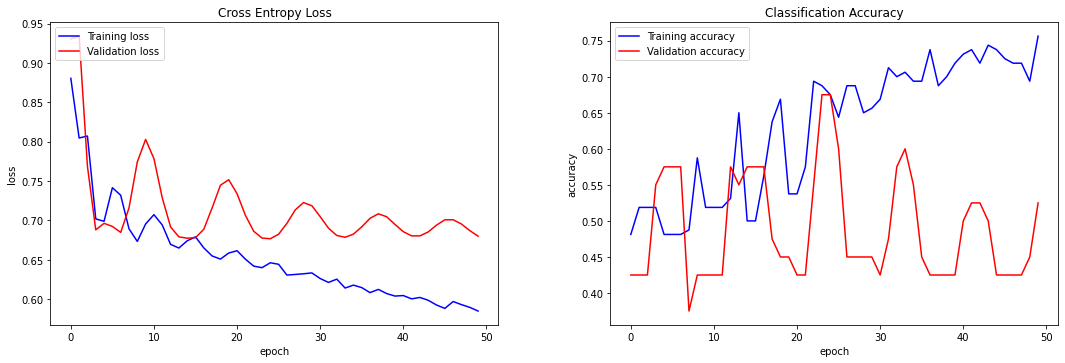

In [ ]:
histories = list()
histories.append(history)
plot_curves(histories)

In [ ]:
scores = model.evaluate(X_test,  y_test, verbose=0)    
print("Model score : %.2f%%" % (scores[1]*100))
print("Model error rate : %.2f%%" % (100-scores[1]*100))           
y_pred = model.predict(X_test, verbose=0)
print("la moyenne de prédiction = ",mean(y_pred))

Model score : 57.50%
Model error rate : 42.50%
la moyenne de prédiction =  0.9973732


In [ ]:
model_from_transfert = load_model('final_modelTransferLearningFMnist.h5')

###VGG16

In [ ]:
# define cnn model
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(124, 124, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
# run the test harness for evaluating a model
my_path = "Data_Project/Tiger-Fox-Elephant/"
my_classes = ['tiger','Tiger_negative_class']
def run_test_harness():
  X,y = create_X_y (my_path, my_classes)
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True) 
  
  y_train.shape = (y_train.shape[0],1)
  y_test.shape = (y_test.shape[0],1)

  X_train = X_train.astype("float32")
  X_test = X_test.astype("float32")

  # define model
  model = define_model()

  # create data generator
  datagen = ImageDataGenerator(rescale=1./255.0, rotation_range=5, zoom_range=0.2, fill_mode="nearest")
  train_it = datagen.flow(X_train, y_train, batch_size=32, shuffle=True)

  val_generator = ImageDataGenerator(rescale=1./255.0)  
  validation_it = val_generator.flow(X_test, y_test, batch_size=32, shuffle=True)

	# fit model
  history = model.fit(train_it,
                       validation_data = validation_it,
                       epochs=20)
  scores =  model.evaluate(X_test,  y_test, verbose=0)    
  
  
  # save model
  # model.save('final_model.h5')
  return history,scores

# entry point, run the test harness
history,scores = run_test_harness()

58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



5/5 [==============================] - 3s 289ms/step - loss: 0.7013 - accuracy: 0.4938 - val_loss: 0.7225 - val_accuracy: 0.4250
Epoch 2/20
5/5 [==============================] - 1s 137ms/step - loss: 0.6838 - accuracy: 0.5688 - val_loss: 0.6694 - val_accuracy: 0.5500
Epoch 3/20
5/5 [==============================] - 1s 134ms/step - loss: 0.6194 - accuracy: 0.7000 - val_loss: 0.5806 - val_accuracy: 0.8000
Epoch 4/20
5/5 [==============================] - 1s 135ms/step - loss: 0.5825 - accuracy: 0.7625 - val_loss: 0.5632 - val_accuracy: 0.8250
Epoch 5/20
5/5 [==============================] - 1s 135ms/step - loss: 0.5515 - accuracy: 0.7625 - val_loss: 0.5199 - val_accuracy: 0.8750
Epoch 6/20
5/5 [==============================] - 1s 138ms/step - loss: 0.5128 - accuracy: 0.8188 - val_loss: 0.4870 - val_accuracy: 0.8750
Epoch 7/20
5/5 [==============================] - 1s 136ms/step - loss: 0.4810 - accuracy: 0.8125 - val_loss: 0.4782 - val_accuracy: 0.8750
Epoch 8/20
5/5 [===============

In [ ]:
histories = list()
histories.append(history)

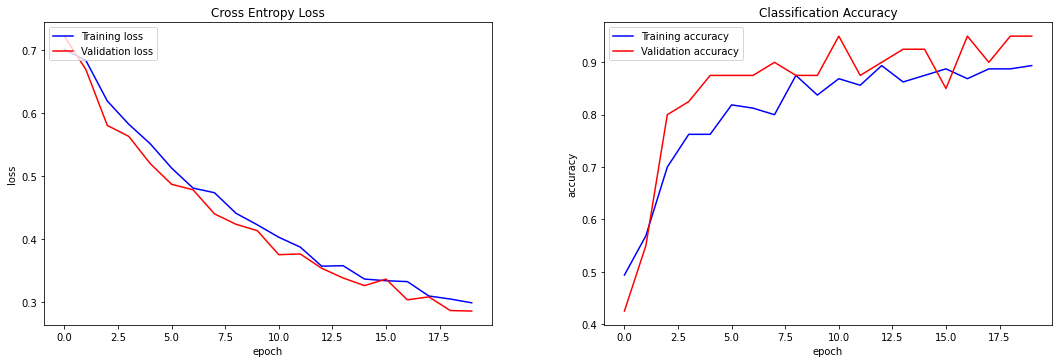

In [ ]:
plot_curves(histories)

In [ ]:
print("Model score : %.2f%%" % (scores[1]*100))
print("Model error rate : %.2f%%" % (100-scores[1]*100))           

Model score : 80.00%
Model error rate : 20.00%


##FOX🦊


###ResNet50

In [ ]:
my_path = "Data_Project/Tiger-Fox-Elephant/"
my_classes = ['fox','Fox_negative_class']

X, y = create_X_y(my_path, my_classes) 

#X = clean_data(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True) 

y_train.shape = (y_train.shape[0],1)
y_test.shape = (y_test.shape[0],1)

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")


print ("X_train et X_test à l'origine : ", X_train.shape, ' ', X_test.shape)
print ("y_test et y_test à l'origine : ", y_train.shape, ' ', y_test.shape)

X_train et X_test à l'origine :  (160, 124, 124, 3)   (40, 124, 124, 3)
y_test et y_test à l'origine :  (160, 1)   (40, 1)


In [ ]:
datagen = ImageDataGenerator(rescale=1./255.0, zoom_range=0.1, fill_mode="nearest")
train_iterator = datagen.flow(X_train, y_train, batch_size=1000, shuffle=True)

val_generator = ImageDataGenerator(rescale=1./255.0)  
val_iterator = val_generator.flow(X_test, y_test, batch_size=500, shuffle=True)

In [ ]:
model=Sequential()
model.add(ResNet50(include_top=False, pooling='max', input_shape=(124,124,3), weights='imagenet'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable= False
# ajout d'une partie classification

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
for i , layer in enumerate(model.layers):
  print(i, layer.name,"-", layer.trainable)

0 resnet50 - False
1 dense_86 - True
2 dense_87 - True


In [ ]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_86 (Dense)            (None, 128)               262272    
                                                                 
 dense_87 (Dense)            (None, 1)                 129       
                                                                 
Total params: 23,850,113
Trainable params: 262,401
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_iterator, epochs=50, validation_data=val_iterator) 

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.7408 - accuracy: 0.4938 - val_loss: 1.0856 - val_accuracy: 0.4750
Epoch 2/50
1/1 [==============================] - 1s 707ms/step - loss: 1.0549 - accuracy: 0.5063 - val_loss: 0.7547 - val_accuracy: 0.4750
Epoch 3/50
1/1 [==============================] - 1s 706ms/step - loss: 0.7555 - accuracy: 0.5063 - val_loss: 0.7252 - val_accuracy: 0.5250
Epoch 4/50
1/1 [==============================] - 1s 715ms/step - loss: 0.7513 - accuracy: 0.4938 - val_loss: 0.8253 - val_accuracy: 0.5250
Epoch 5/50
1/1 [==============================] - 1s 699ms/step - loss: 0.8527 - accuracy: 0.4938 - val_loss: 0.7759 - val_accuracy: 0.5250
Epoch 6/50
1/1 [==============================] - 1s 707ms/step - loss: 0.7912 - accuracy: 0.4938 - val_loss: 0.7006 - val_accuracy: 0.5250
Epoch 7/50
1/1 [==============================] - 1s 715ms/step - loss: 0.7006 - accuracy: 0.5000 - val_loss: 0.7167 - val_accuracy: 0.4750
Epoch 8/50
1/1 [=======

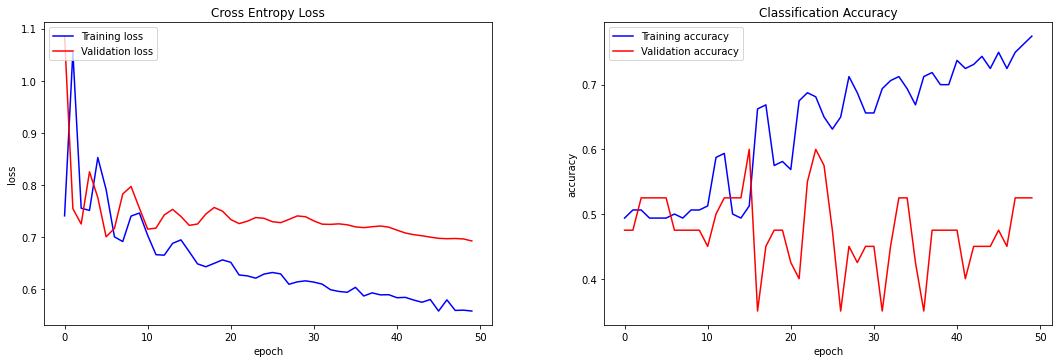

In [ ]:
histories = list()
histories.append(history)
plot_curves(histories)

In [ ]:
scores = model.evaluate(X_test,  y_test, verbose=0)    
print("Model score : %.2f%%" % (scores[1]*100))
print("Model error rate : %.2f%%" % (100-scores[1]*100))           
y_pred = model.predict(X_test, verbose=0)
print("la moyenne de prédiction = ",mean(y_pred))

Model score : 52.50%
Model error rate : 47.50%
la moyenne de prédiction =  0.00631019


###VGG16

In [ ]:
# define cnn model
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(124, 124, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
# run the test harness for evaluating a model
my_path = "Data_Project/Tiger-Fox-Elephant/"
my_classes = ['fox','Fox_negative_class']
def run_test_harness():
  X,y = create_X_y (my_path, my_classes)
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True) 
  
  y_train.shape = (y_train.shape[0],1)
  y_test.shape = (y_test.shape[0],1)

  X_train = X_train.astype("float32")
  X_test = X_test.astype("float32")

  # define model
  model = define_model()

  # create data generator
  datagen = ImageDataGenerator(rescale=1./255.0, rotation_range=5, zoom_range=0.2, fill_mode="nearest")
  train_it = datagen.flow(X_train, y_train, batch_size=32, shuffle=True)

  val_generator = ImageDataGenerator(rescale=1./255.0)  
  validation_it = val_generator.flow(X_test, y_test, batch_size=32, shuffle=True)

	# fit model
  history = model.fit(train_it,
                       validation_data = validation_it,
                       epochs=50)
  scores =  model.evaluate(X_test,  y_test, verbose=0)    
  
  
  # save model
  # model.save('final_model.h5')
  return history,scores

# entry point, run the test harness
history,scores = run_test_harness()

Epoch 1/50
5/5 [==============================] - 2s 201ms/step - loss: 0.6846 - accuracy: 0.6000 - val_loss: 0.7788 - val_accuracy: 0.5500
Epoch 2/50
5/5 [==============================] - 1s 144ms/step - loss: 0.7443 - accuracy: 0.5688 - val_loss: 0.6674 - val_accuracy: 0.5750
Epoch 3/50
5/5 [==============================] - 1s 145ms/step - loss: 0.6609 - accuracy: 0.5938 - val_loss: 0.5577 - val_accuracy: 0.7000
Epoch 4/50
5/5 [==============================] - 1s 142ms/step - loss: 0.5835 - accuracy: 0.6187 - val_loss: 0.5099 - val_accuracy: 0.8500
Epoch 5/50
5/5 [==============================] - 1s 142ms/step - loss: 0.5483 - accuracy: 0.7625 - val_loss: 0.4943 - val_accuracy: 0.8000
Epoch 6/50
5/5 [==============================] - 1s 144ms/step - loss: 0.4547 - accuracy: 0.8438 - val_loss: 0.4609 - val_accuracy: 0.7750
Epoch 7/50
5/5 [==============================] - 1s 139ms/step - loss: 0.4536 - accuracy: 0.8062 - val_loss: 0.4396 - val_accuracy: 0.8500
Epoch 8/50
5/5 [====

In [ ]:
histories = list()
histories.append(history)

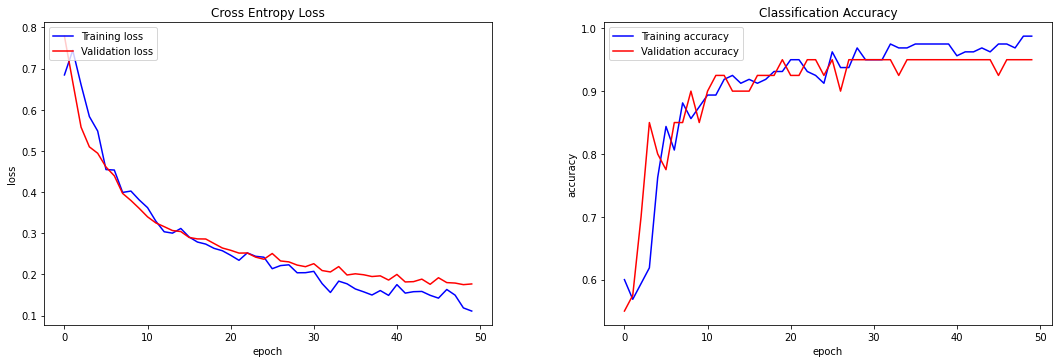

In [ ]:
plot_curves(histories)

In [ ]:
print("Model score : %.2f%%" % (scores[1]*100))
print("Model error rate : %.2f%%" % (100-scores[1]*100))           

Model score : 92.50%
Model error rate : 7.50%


##Elephent🐘


###ResNet50

In [ ]:
my_path = "Data_Project/Tiger-Fox-Elephant/"
my_classes = ['elephant','Elephant_negative_class']

X, y = create_X_y(my_path, my_classes) 

#X = clean_data(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True) 

y_train.shape = (y_train.shape[0],1)
y_test.shape = (y_test.shape[0],1)

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")


print ("X_train et X_test à l'origine : ", X_train.shape, ' ', X_test.shape)
print ("y_test et y_test à l'origine : ", y_train.shape, ' ', y_test.shape)

X_train et X_test à l'origine :  (160, 124, 124, 3)   (40, 124, 124, 3)
y_test et y_test à l'origine :  (160, 1)   (40, 1)


In [ ]:
datagen = ImageDataGenerator(rescale=1./255.0, zoom_range=0.1, fill_mode="nearest")
train_iterator = datagen.flow(X_train, y_train, batch_size=1000, shuffle=True)

val_generator = ImageDataGenerator(rescale=1./255.0)  
val_iterator = val_generator.flow(X_test, y_test, batch_size=500, shuffle=True)

In [ ]:
model=Sequential()
model.add(ResNet50(include_top=False, pooling='max', input_shape=(124,124,3), weights='imagenet'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable= False
# ajout d'une partie classification

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
for i , layer in enumerate(model.layers):
  print(i, layer.name,"-", layer.trainable)

0 resnet50 - False
1 dense_102 - True
2 dense_103 - True


In [ ]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_102 (Dense)           (None, 128)               262272    
                                                                 
 dense_103 (Dense)           (None, 1)                 129       
                                                                 
Total params: 23,850,113
Trainable params: 262,401
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_iterator, epochs=50, validation_data=val_iterator) 

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 1.7839 - accuracy: 0.4938 - val_loss: 0.7171 - val_accuracy: 0.5250
Epoch 2/50
1/1 [==============================] - 1s 715ms/step - loss: 0.7425 - accuracy: 0.4938 - val_loss: 1.0988 - val_accuracy: 0.4750
Epoch 3/50
1/1 [==============================] - 1s 703ms/step - loss: 1.0500 - accuracy: 0.5063 - val_loss: 1.2129 - val_accuracy: 0.4750
Epoch 4/50
1/1 [==============================] - 1s 715ms/step - loss: 1.1578 - accuracy: 0.5063 - val_loss: 0.9901 - val_accuracy: 0.4750
Epoch 5/50
1/1 [==============================] - 1s 757ms/step - loss: 0.9510 - accuracy: 0.5063 - val_loss: 0.7356 - val_accuracy: 0.4750
Epoch 6/50
1/1 [==============================] - 1s 732ms/step - loss: 0.7260 - accuracy: 0.5063 - val_loss: 0.6823 - val_accuracy: 0.5250
Epoch 7/50
1/1 [==============================] - 1s 724ms/step - loss: 0.6990 - accuracy: 0.4938 - val_loss: 0.7748 - val_accuracy: 0.5250
Epoch 8/50
1/1 [=======

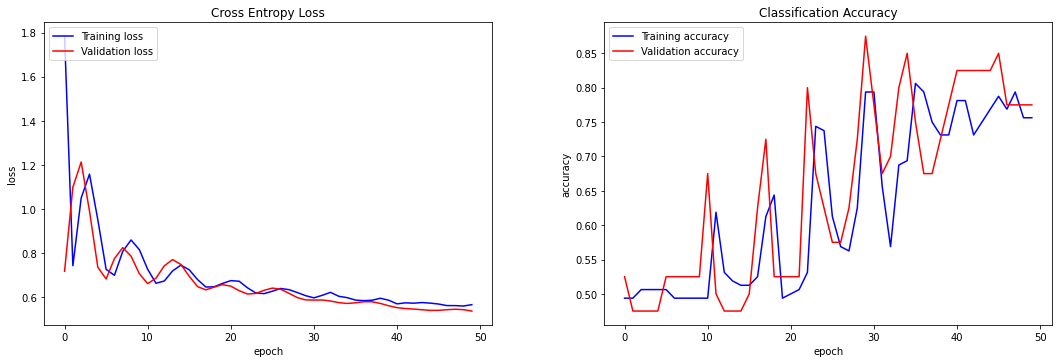

In [ ]:
histories = list()
histories.append(history)
plot_curves(histories)

In [ ]:
scores = model.evaluate(X_test,  y_test, verbose=0)    
print("Model score : %.2f%%" % (scores[1]*100))
print("Model error rate : %.2f%%" % (100-scores[1]*100))           
y_pred = model.predict(X_test, verbose=0)
print("la moyenne de prédiction = ",mean(y_pred))

Model score : 52.50%
Model error rate : 47.50%
la moyenne de prédiction =  0.9999992


###VGG16

In [ ]:
# define cnn model
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(124, 124, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
# run the test harness for evaluating a model
my_path = "Data_Project/Tiger-Fox-Elephant/"
my_classes = ['elephant','Elephant_negative_class']
def run_test_harness():
  X,y = create_X_y (my_path, my_classes)
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True) 
  
  y_train.shape = (y_train.shape[0],1)
  y_test.shape = (y_test.shape[0],1)

  X_train = X_train.astype("float32")
  X_test = X_test.astype("float32")

  # define model
  model = define_model()

  # create data generator
  datagen = ImageDataGenerator(rescale=1./255.0, rotation_range=5, zoom_range=0.2, fill_mode="nearest")
  train_it = datagen.flow(X_train, y_train, batch_size=32, shuffle=True)

  val_generator = ImageDataGenerator(rescale=1./255.0)  
  validation_it = val_generator.flow(X_test, y_test, batch_size=32, shuffle=True)

	# fit model
  history = model.fit(train_it,
                       validation_data = validation_it,
                       epochs=50)
  scores =  model.evaluate(X_test,  y_test, verbose=0)    
  
  
  # save model
  # model.save('final_model.h5')
  return history,scores

# entry point, run the test harness
history,scores = run_test_harness()

Epoch 1/50
5/5 [==============================] - 2s 197ms/step - loss: 0.8021 - accuracy: 0.5250 - val_loss: 0.9791 - val_accuracy: 0.4000
Epoch 2/50
5/5 [==============================] - 1s 141ms/step - loss: 0.7239 - accuracy: 0.6062 - val_loss: 0.6139 - val_accuracy: 0.6750
Epoch 3/50
5/5 [==============================] - 1s 143ms/step - loss: 0.6690 - accuracy: 0.5625 - val_loss: 0.6242 - val_accuracy: 0.5750
Epoch 4/50
5/5 [==============================] - 1s 140ms/step - loss: 0.5775 - accuracy: 0.7312 - val_loss: 0.5425 - val_accuracy: 0.8250
Epoch 5/50
5/5 [==============================] - 1s 142ms/step - loss: 0.5083 - accuracy: 0.8125 - val_loss: 0.4927 - val_accuracy: 0.8750
Epoch 6/50
5/5 [==============================] - 1s 142ms/step - loss: 0.4846 - accuracy: 0.8125 - val_loss: 0.5036 - val_accuracy: 0.7250
Epoch 7/50
5/5 [==============================] - 1s 142ms/step - loss: 0.4345 - accuracy: 0.8375 - val_loss: 0.4107 - val_accuracy: 0.8750
Epoch 8/50
5/5 [====

In [ ]:
histories = list()
histories.append(history)

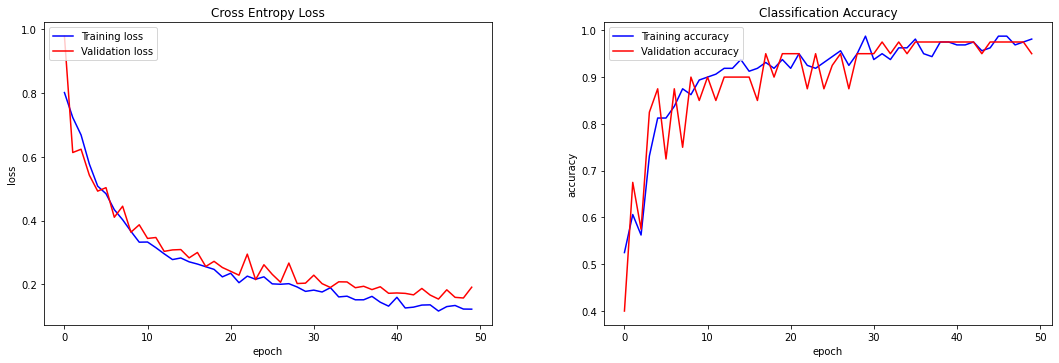

In [ ]:
plot_curves(histories)

In [ ]:
print("Model score : %.2f%%" % (scores[1]*100))
print("Model error rate : %.2f%%" % (100-scores[1]*100))           

Model score : 95.00%
Model error rate : 5.00%
